In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
import json
import pickle
import random
import time
import os
import requests
from collections import Counter
import unittest
from google.colab import drive

# NLTK Resources Download

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Loading Dataset

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Financial_Sentiment_Analysis/data.csv"
df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3130
positive,1852
negative,860


In [ ]:
df.isna().sum()

,0
Sentence,0
Sentiment,0


In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(5836, 2)

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


# Plotting Sentiment Distribution

In [ ]:
# Plotting the distribution of sentiment
def plot_sentiment_distribution(df):
    sentiment_counts = df['Sentiment'].value_counts()

    ax = sentiment_counts.plot(kind='bar')
    plt.title('Distribution of Sentiment', fontsize=10)
    plt.xlabel('Sentiment', fontsize=8)
    plt.ylabel('Count', fontsize=8)
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8)

    for i, count in enumerate(sentiment_counts):
        ax.text(i, count + 0.1, str(count), ha='center', fontsize=8)

    plt.show()

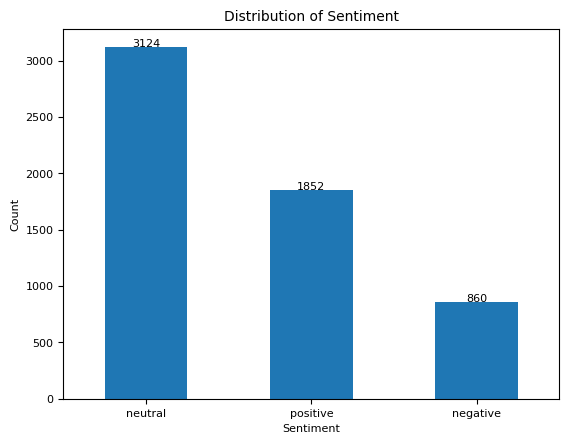

In [ ]:
plot_sentiment_distribution(df)

# Balancing Dataset

In [ ]:
# Separate the data by class
neutral_df = df[df['Sentiment'] == 'neutral']
positive_df = df[df['Sentiment'] == 'positive']
negative_df = df[df['Sentiment'] == 'negative']

# 1. Keep the 'neutral' class as is (3124 examples)
neutral_df_balanced = neutral_df  # No changes needed for neutral

# 2. Upsample the 'positive' class (increase to 3124 examples)
positive_df_upsampled = resample(positive_df,
                                 replace=True,
                                 n_samples=3124,
                                 random_state=42)

# 3. Upsample the 'negative' class (increase to 3124 examples)
negative_df_upsampled = resample(negative_df,
                                 replace=True,
                                 n_samples=3124,
                                 random_state=42)

# 4. Combine all the balanced data into a new dataframe
df = pd.concat([neutral_df_balanced, positive_df_upsampled, negative_df_upsampled])

# Verify that the dataframe is now balanced
print(df['Sentiment'].value_counts())

Sentiment
neutral     3124
positive    3124
negative    3124
Name: count, dtype: int64


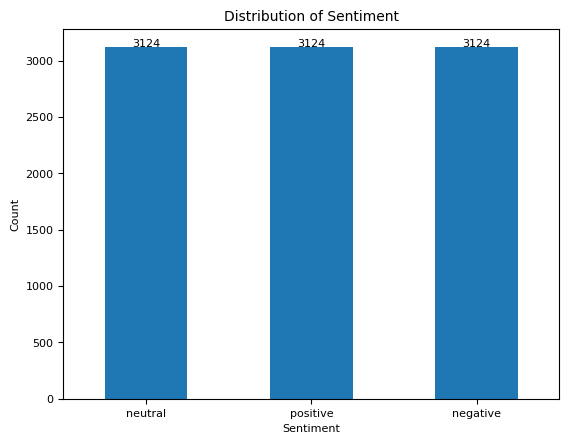

In [ ]:
# Plot the distribution of sentiment
plot_sentiment_distribution(df)

# Generating Word Cloud

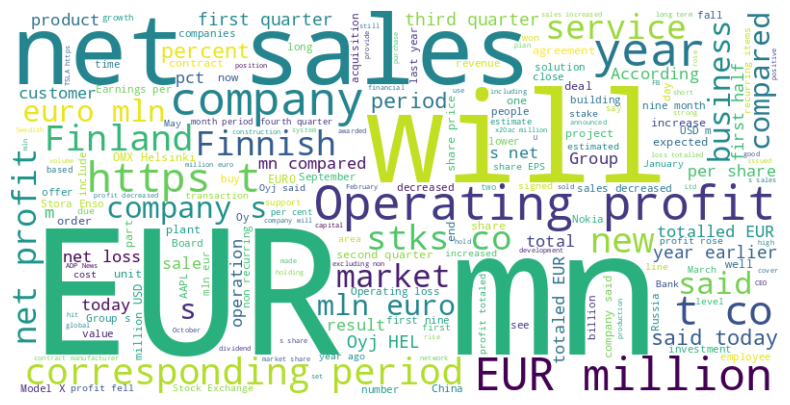

In [ ]:
# Combine all the sentences from the 'Sentence' column into one string
text = ' '.join(df['Sentence'])

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axes
plt.show()


# Generating Word Frequency Plot

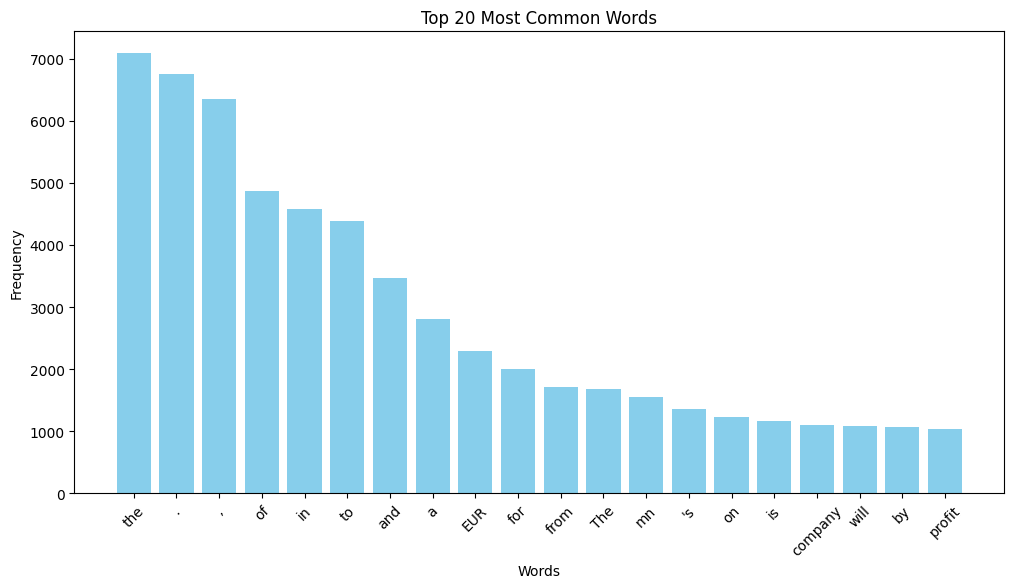

In [ ]:
# Combine all the sentences from the correct column
text = ' '.join(df['Sentence'])

# Tokenize the text (split into words)
words = text.split()

# Count the frequency of each word
word_freq = Counter(words)

# Create a DataFrame from the word frequency dictionary
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Select the top 20 most common words
top_words = word_freq_df.head(20)

# Generate the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Text Preprocessing Functions

In [ ]:
def count_tokens(text):
    """Counts the number of tokens in a string or pandas Series."""
    if isinstance(text, pd.Series):
        total_count = text.apply(lambda x: len([token for token in word_tokenize(str(x)) if token.isalnum()])).sum()
    else:
        total_count = len([token for token in word_tokenize(str(text)) if token.isalnum()])
    return total_count

def expand_contractions(text):
    """Expands common contractions in English."""
    contractions = {
        "can't": "cannot",
        "don't": "do not",
        "won't": "will not",
        "I'm": "I am",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "they're": "they are",
        "you're": "you are",
        "we're": "we are",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
    }

    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded, text)

    return text

def lemmatize_tokens(tokens):
    """Lemmatizes the tokens (implement as needed)."""
    # Placeholder for lemmatization logic (not implemented here)
    return tokens

def remove_emojis(text):
    """Removes emojis from a string."""
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]")
    return emoji_pattern.sub('', text)

def remove_html_tags(text):
    """Removes HTML tags from a string."""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_negation(text):
    """Removes negation words and replaces them with their positive form."""
    negation_patterns = {
        "don't": "do",
        "doesn't": "does",
        "won't": "will",
        "can't": "can",
        "isn't": "is",
        "aren't": "are",
        "wasn't": "was",
        "weren't": "were",
        "no": "yes",
        "not": ""
    }

    for negation, replacement in negation_patterns.items():
        text = re.sub(r'\b' + re.escape(negation) + r'\b', replacement, text, flags=re.IGNORECASE)

    return text.strip()

def remove_punctuation(text):
    """Removes punctuation from a string."""
    return re.sub(r'[^\w\s]', '', text)

def remove_special_characters(text):
    """Removes special characters from a string."""
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_stopwords(tokens):
    """Removes stopwords from a list of tokens."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.lower() not in stop_words]

def remove_urls(text):
    """Removes URLs from a string."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def stem_tokens(tokens):
    """Stems the tokens."""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def to_lower(text):
    """Converts a string to lowercase."""
    return text.lower()

def tokenize_text(text):
    """Tokenizes a string into words."""
    return word_tokenize(text)

# Text Processing Unit Tests

In [ ]:
class TestTextProcessing(unittest.TestCase):

    def test_count_tokens_string(self):
        original_text = "This is a test."
        total_tokens = count_tokens(original_text)
        self.assertEqual(total_tokens, 4)

    def test_count_tokens_series_of_strings(self):
        original_text = pd.Series(["This is the first test.", "This is the second test."])
        total_tokens = count_tokens(original_text)
        self.assertEqual(total_tokens, 10)

    def test_expand_contractions(self):
        original_text = "I'm not going to the party."
        transformed_text = expand_contractions(original_text)
        self.assertEqual(transformed_text, "I am not going to the party.")

    def test_lemmatize_tokens(self):
        tokens = ["running", "ran", "swimming", "swam"]
        transformed_tokens = lemmatize_tokens(tokens)
        self.assertEqual(transformed_tokens, tokens)

    def test_remove_emojis(self):
        original_text = "Investing is exciting 😊 money_bag"
        transformed_text = remove_emojis(original_text)
        self.assertEqual(transformed_text, "Investing is exciting  money_bag")

    def test_remove_html_tags(self):
        original_text = "<p>This is a <strong>test</strong>.</p>"
        transformed_text = remove_html_tags(original_text)
        self.assertEqual(transformed_text, "This is a test.")

    def test_remove_negation(self):
        original_text = "I don't think this investment is bad."
        transformed_text = remove_negation(original_text)
        self.assertEqual(transformed_text, "I do think this investment is bad.")

    def test_remove_punctuation(self):
        original_text = "Hello, world!"
        transformed_text = remove_punctuation(original_text)
        self.assertEqual(transformed_text, "Hello world")

    def test_remove_special_characters(self):
        original_text = "Special @characters# should be $removed!"
        transformed_text = remove_special_characters(original_text)
        self.assertEqual(transformed_text, "Special characters should be removed")

    def test_remove_stopwords(self):
        tokens = ["This", "is", "a", "test"]
        transformed_tokens = remove_stopwords(tokens)
        self.assertEqual(transformed_tokens, ["test"])

    def test_remove_urls(self):
        original_text = "Visit us at https://www.example.com"
        transformed_text = remove_urls(original_text)
        self.assertEqual(transformed_text, "Visit us at ")

    def test_stem_tokens(self):
        tokens = ["investing", "investment", "invest"]
        transformed_tokens = stem_tokens(tokens)
        self.assertEqual(transformed_tokens, ["invest", "invest", "invest"])

    def test_to_lower(self):
        original_text = "HELLO World"
        transformed_text = to_lower(original_text)
        self.assertEqual(transformed_text, "hello world")

    def test_tokenize_text(self):
        original_text = "The revenue growth rate is impressive."
        transformed_text = tokenize_text(original_text)
        self.assertEqual(transformed_text, ["The", "revenue", "growth", "rate", "is", "impressive", "."])


# Run the test:
if __name__ == '__main__':
    unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestTextProcessing))

..............
----------------------------------------------------------------------
Ran 14 tests in 0.074s

OK


# Text Preprocessing Pipeline

In [ ]:
# Total tokens before preprocessing
print(f"Total tokens before preprocessing: {count_tokens(df['Sentence'])}")

# Create a DataFrame to store the token count after each operation
token_count_df = pd.DataFrame(columns=["Operation", "Token Count After"])

# Define the text processing operations
operations = [
    remove_html_tags,
    remove_urls,
    remove_emojis,
    expand_contractions,
    remove_negation,
    remove_special_characters,
    remove_punctuation,
    to_lower,
    tokenize_text,
    remove_stopwords,
    lemmatize_tokens,
    stem_tokens,
]

# Apply the text processing operations
for operation in operations:
    print(f"Applying operation: {operation.__name__}")
    df["Sentence"] = df["Sentence"].apply(operation)

    # Count tokens after each operation
    token_count = count_tokens(df['Sentence'])

    # Store the results in the DataFrame
    token_count_df = pd.concat(
        [token_count_df, pd.DataFrame({"Operation": [operation.__name__], "Token Count After": [token_count]})],
        ignore_index=True
    )

# Total tokens after preprocessing
print(f"Total tokens after preprocessing: {count_tokens(df['Sentence'])}")

# Display the token count DataFrame
token_count_df

Total tokens before preprocessing: 162449
Applying operation: remove_html_tags
Applying operation: remove_urls
Applying operation: remove_emojis
Applying operation: expand_contractions
Applying operation: remove_negation
Applying operation: remove_special_characters
Applying operation: remove_punctuation
Applying operation: to_lower
Applying operation: tokenize_text
Applying operation: remove_stopwords
Applying operation: lemmatize_tokens
Applying operation: stem_tokens
Total tokens after preprocessing: 1367


,Operation,Token Count After
0,remove_html_tags,162440
1,remove_urls,161814
2,remove_emojis,161814
3,expand_contractions,161878
4,remove_negation,161685
5,remove_special_characters,171415
6,remove_punctuation,171415
7,to_lower,171415
8,tokenize_text,4487
9,remove_stopwords,1367


# Concatenating Tokens into Text

In [ ]:
# Concatenate all tokens into a single string
all_tokens = ' '.join(df['Sentence'].astype(str))

# Generating Word Cloud, Word Frequency Plot, and Top 10 Most Frequent Terms

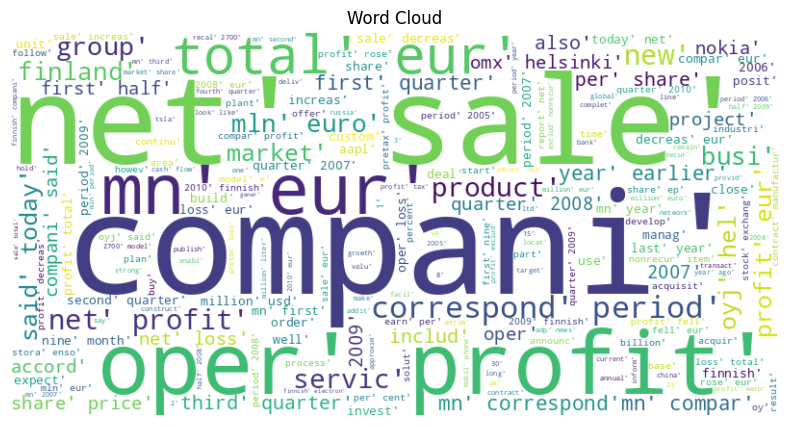

In [ ]:
all_text = ' '.join(all_tokens)
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

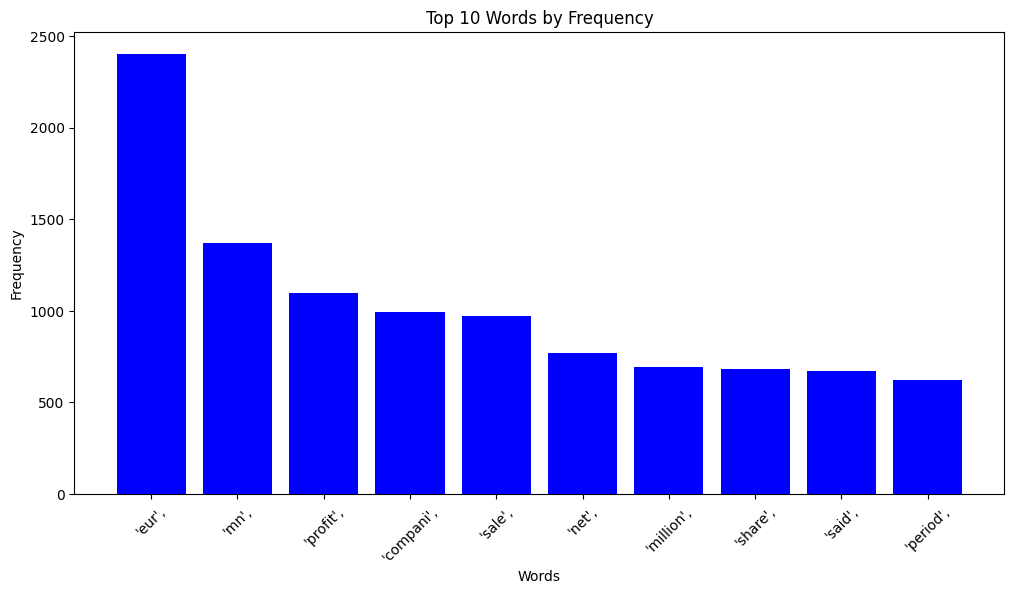

In [ ]:
# Calculate word frequency
word_frequency = Counter(all_tokens.split())

# Create a DataFrame for plotting
freq_df = pd.DataFrame(word_frequency.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the word frequency
plt.figure(figsize=(12, 6))
plt.bar(freq_df['Word'][:10], freq_df['Frequency'][:10], color='blue')
plt.title('Top 10 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate word frequency
word_frequency = Counter(all_tokens.split())

# Get the top 10 most frequent terms
top_10_terms = word_frequency.most_common(10)

# Create a DataFrame for the top 10 terms
top_10_df = pd.DataFrame(top_10_terms, columns=['Term', 'Frequency'])

# Display the top 10 terms DataFrame
top_10_df

,Term,Frequency
0,"'eur',",2402
1,"'mn',",1372
2,"'profit',",1099
3,"'compani',",994
4,"'sale',",970
5,"'net',",769
6,"'million',",695
7,"'share',",681
8,"'said',",674
9,"'period',",624


# Feature Engineering with TF-IDF Vectorization

In [ ]:
labels = df['Sentiment']

all_sentences = df['Sentence'].astype(str).tolist()

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
bow = vectorizer.fit_transform(all_sentences)

vectorizer2 = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
bow2 = vectorizer2.fit_transform(all_sentences)

# Use Chi-Squared test to select the best features
selected_features = SelectKBest(chi2, k=5000).fit(bow2, labels).get_support(indices=True)
bestfeatures = [vectorizer2.get_feature_names_out()[t] for t in selected_features]

# Create a TF-IDF vectorizer with the top 5000 features
vectorizer3 = TfidfVectorizer(ngram_range=(1, 2), min_df=10, vocabulary=bestfeatures)
# Create the bag of words with selected features
bow3 = vectorizer3.fit_transform(all_sentences)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2627. All the features will be returned.
  warnings.warn(


# Train-Test Split for Model Training

In [ ]:
# Step 1: Split the data into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(bow3, labels, test_size=0.30, stratify=labels, random_state=42)

# Step 2: Split the temporary set into validation (20%) and testing (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, stratify=y_temp, random_state=42)

# Model Training and Confusion Matrix Plotting

Choice of Macro Average Calculation
In this project, Macro Average was selected for evaluating metrics like precision, recall, and F1-score because all classes (positive, neutral, negative) were treated equally, irrespective of their size.

**Macro Average:**

Each class's metric (e.g., precision) was calculated individually.
The arithmetic mean of these metrics was then computed without considering class imbalance.
Pros:

Equal contribution from all classes.

Cons:

Smaller classes might disproportionately influence the final result in imbalanced datasets.

Example: Precision was calculated for the three classes, followed by averaging those values.

**Micro Average**
Micro Average aggregates true positives, false positives, and false negatives across all classes, treating the problem as binary.

How it Works:

Sum all true positives (TP), false positives (FP), and false negatives (FN).
Compute the metric using these totals.
Pros:

Larger classes have more influence, beneficial for imbalanced datasets.

Cons:

Smaller classes may have negligible impact if significantly outnumbered.

Example: If one class (positive) has many more samples, it dominates the metric outcome, making Micro Average suitable for overall model performance evaluation in imbalanced datasets.

**Weighted Average**
In the Weighted Average, each class's metric is weighted by its sample size.

How it Works:

Calculate the metric for each class.
Weight each metric by class size.
Compute a weighted average of the metrics.
Pros:

Accounts for both performance and class size, aiding in imbalanced distributions.

Cons:

Larger classes can still overshadow smaller ones, potentially hiding poor performance.

Example: If the positive class has 70% of samples and the negative class has 10%, each metric is weighted according to these proportions.

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                cbar=False, annot_kws={"size": 8})
    plt.title(f'Confusion Matrix for {classifier_name}', fontsize=10)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.show()

# Function to train and evaluate classifiers
def train_and_evaluate_classifier(classifier, classifier_name):
    start_time = time.time()

    # Define the scoring metrics (adjusted for multiclass)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1_score': make_scorer(f1_score, average='macro')
    }

    # Perform cross-validation on the training set
    cross_validation_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=scoring)

    # Calculate cross-validation metrics
    mean_accuracy = np.mean(cross_validation_results['test_accuracy'])
    mean_precision = np.mean(cross_validation_results['test_precision'])
    mean_recall = np.mean(cross_validation_results['test_recall'])
    mean_f1_score = np.mean(cross_validation_results['test_f1_score'])
    std_accuracy = np.std(cross_validation_results['test_accuracy'])
    std_precision = np.std(cross_validation_results['test_precision'])
    std_recall = np.std(cross_validation_results['test_recall'])
    std_f1_score = np.std(cross_validation_results['test_f1_score'])

    # Fit the classifier on the training set
    classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    predicted = classifier.predict(X_val)

    # Calculate the Cohen's Kappa and confusion matrix
    cohen_kappa = cohen_kappa_score(y_val, predicted)
    cm = confusion_matrix(y_val, predicted)

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Prepare results
    r = {
        'classifier': classifier_name,
        'mean_accuracy': mean_accuracy,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1_score': mean_f1_score,
        'std_accuracy': std_accuracy,
        'std_precision': std_precision,
        'std_recall': std_recall,
        'std_f1_score': std_f1_score,
        'cohen_kappa': cohen_kappa,
        'confusion_matrix': cm,
        'elapsed_time': elapsed_time
    }

    print(r)
    plot_confusion_matrix(cm, classifier_name)
    return r

{'classifier': 'Naive Bayes', 'mean_accuracy': 0.7301829268292682, 'mean_precision': 0.733234562694413, 'mean_recall': 0.7301836584711731, 'mean_f1_score': 0.7303123868565911, 'std_accuracy': 0.010472904900803458, 'std_precision': 0.00949813309527118, 'std_recall': 0.010476775507341185, 'std_f1_score': 0.010659279459957104, 'cohen_kappa': 0.590186389575954, 'confusion_matrix': array([[471,  93,  60],
       [114, 444,  67],
       [ 68, 110, 447]]), 'elapsed_time': 0.5479111671447754}


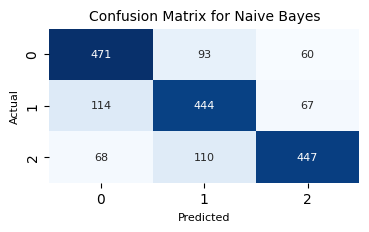

{'classifier': 'Decision Tree', 'mean_accuracy': 0.7858231707317074, 'mean_precision': 0.7900551021662479, 'mean_recall': 0.78583221006656, 'mean_f1_score': 0.7794288553259102, 'std_accuracy': 0.009820197200247807, 'std_precision': 0.009473002292732766, 'std_recall': 0.009901220252395338, 'std_f1_score': 0.010402994059443728, 'cohen_kappa': 0.7086613265225497, 'confusion_matrix': array([[584,  29,  11],
       [154, 372,  99],
       [ 21,  50, 554]]), 'elapsed_time': 5.293672323226929}


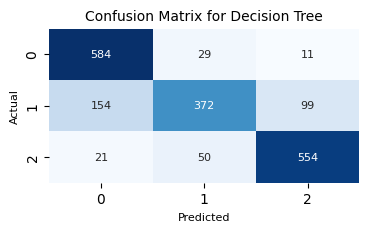

{'classifier': 'Support Vector Machine', 'mean_accuracy': 0.8268292682926829, 'mean_precision': 0.8304064285544881, 'mean_recall': 0.8268378908358847, 'mean_f1_score': 0.8270622727459027, 'std_accuracy': 0.004995722441516446, 'std_precision': 0.005053361967413276, 'std_recall': 0.004972087480575626, 'std_f1_score': 0.004949111477498214, 'cohen_kappa': 0.7598780170075727, 'confusion_matrix': array([[557,  47,  20],
       [112, 471,  42],
       [ 15,  64, 546]]), 'elapsed_time': 35.160359382629395}


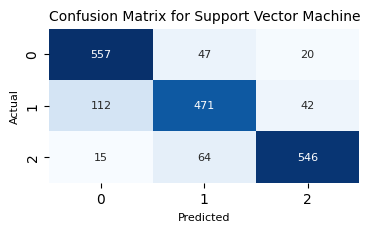

{'classifier': 'Random Forest', 'mean_accuracy': 0.8243902439024389, 'mean_precision': 0.8258092216504508, 'mean_recall': 0.8243994441135596, 'mean_f1_score': 0.8237882340962577, 'std_accuracy': 0.010095561396218594, 'std_precision': 0.010975898617557088, 'std_recall': 0.010060970916121802, 'std_f1_score': 0.010068569818299934, 'cohen_kappa': 0.7582775135148525, 'confusion_matrix': array([[556,  53,  15],
       [119, 460,  46],
       [ 12,  57, 556]]), 'elapsed_time': 75.50014901161194}


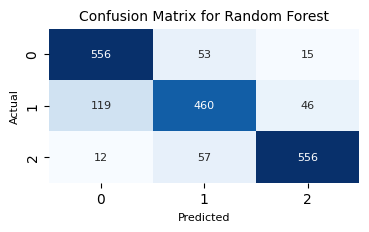

{'classifier': 'Logistic Regression', 'mean_accuracy': 0.7809451219512196, 'mean_precision': 0.7819431751842506, 'mean_recall': 0.7809535751230368, 'mean_f1_score': 0.7801269512333835, 'std_accuracy': 0.005466591791780814, 'std_precision': 0.005101276194796207, 'std_recall': 0.005419486137359302, 'std_f1_score': 0.005464680991910655, 'cohen_kappa': 0.6630278097281728, 'confusion_matrix': array([[523,  62,  39],
       [118, 426,  81],
       [ 36,  85, 504]]), 'elapsed_time': 1.4920804500579834}


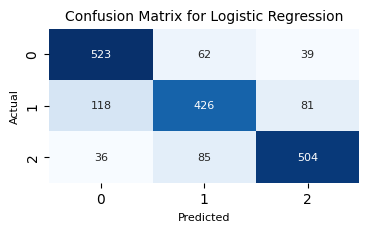

{'classifier': 'Gradient Boosting', 'mean_accuracy': 0.708841463414634, 'mean_precision': 0.7233702423884252, 'mean_recall': 0.7088485557749843, 'mean_f1_score': 0.7110170214277973, 'std_accuracy': 0.006765957628406129, 'std_precision': 0.008658291628192843, 'std_recall': 0.006760920089641487, 'std_f1_score': 0.00683950366491415, 'cohen_kappa': 0.5301460682699808, 'confusion_matrix': array([[435, 147,  42],
       [112, 446,  67],
       [ 61, 158, 406]]), 'elapsed_time': 47.347577810287476}


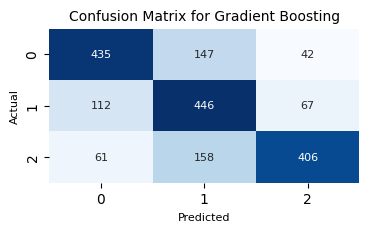

{'classifier': 'k-Nearest Neighbors', 'mean_accuracy': 0.573170731707317, 'mean_precision': 0.6328718876631392, 'mean_recall': 0.5731022016028756, 'mean_f1_score': 0.5576665129942204, 'std_accuracy': 0.03752292081589094, 'std_precision': 0.021071016960041954, 'std_recall': 0.03765507470339492, 'std_f1_score': 0.04530317123392164, 'cohen_kappa': 0.43099620312248443, 'confusion_matrix': array([[559,  50,  15],
       [300, 292,  33],
       [176, 137, 312]]), 'elapsed_time': 1.769667625427246}


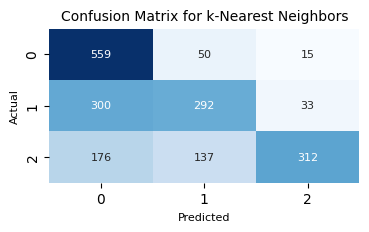

{'classifier': 'Extra Trees', 'mean_accuracy': 0.8467987804878048, 'mean_precision': 0.8490782381518713, 'mean_recall': 0.8468059169165718, 'mean_f1_score': 0.8459933604208025, 'std_accuracy': 0.008528415079694722, 'std_precision': 0.008711748137297694, 'std_recall': 0.008492801278418416, 'std_f1_score': 0.008466404092350619, 'cohen_kappa': 0.7846931048371081, 'confusion_matrix': array([[582,  28,  14],
       [115, 468,  42],
       [ 14,  56, 555]]), 'elapsed_time': 108.28010892868042}


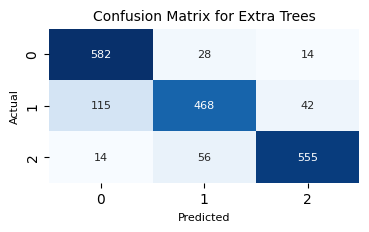

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12505
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 696
[LightGBM] [Info] Start training from score -1.098231
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12718
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 714
[LightGBM] [Info] Start training from score -1.098231
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Star

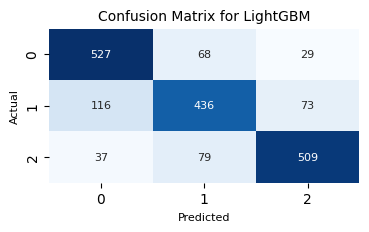

In [ ]:
# Create a dictionary of classifiers
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier()
}

results = []

# Train and evaluate the classifiers
for classifier_name, classifier in classifiers.items():
    results.append(train_and_evaluate_classifier(classifier, classifier_name))

In [ ]:
# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
df_results.sort_values(by='mean_accuracy', ascending=False)

,classifier,mean_accuracy,mean_precision,mean_recall,mean_f1_score,std_accuracy,std_precision,std_recall,std_f1_score,cohen_kappa,confusion_matrix,elapsed_time
7,Extra Trees,0.846799,0.849078,0.846806,0.845993,0.008528,0.008712,0.008493,0.008466,0.784693,"[[582, 28, 14], [115, 468, 42], [14, 56, 555]]",108.280109
2,Support Vector Machine,0.826829,0.830406,0.826838,0.827062,0.004996,0.005053,0.004972,0.004949,0.759878,"[[557, 47, 20], [112, 471, 42], [15, 64, 546]]",35.160359
3,Random Forest,0.824390,0.825809,0.824399,0.823788,0.010096,0.010976,0.010061,0.010069,0.758278,"[[556, 53, 15], [119, 460, 46], [12, 57, 556]]",75.500149
1,Decision Tree,0.785823,0.790055,0.785832,0.779429,0.009820,0.009473,0.009901,0.010403,0.708661,"[[584, 29, 11], [154, 372, 99], [21, 50, 554]]",5.293672
4,Logistic Regression,0.780945,0.781943,0.780954,0.780127,0.005467,0.005101,0.005419,0.005465,0.663028,"[[523, 62, 39], [118, 426, 81], [36, 85, 504]]",1.492080
8,LightGBM,0.765091,0.766317,0.765105,0.764354,0.009954,0.009424,0.009927,0.010268,0.678236,"[[527, 68, 29], [116, 436, 73], [37, 79, 509]]",17.997863
0,Naive Bayes,0.730183,0.733235,0.730184,0.730312,0.010473,0.009498,0.010477,0.010659,0.590186,"[[471, 93, 60], [114, 444, 67], [68, 110, 447]]",0.547911
5,Gradient Boosting,0.708841,0.723370,0.708849,0.711017,0.006766,0.008658,0.006761,0.006840,0.530146,"[[435, 147, 42], [112, 446, 67], [61, 158, 406]]",47.347578
6,k-Nearest Neighbors,0.573171,0.632872,0.573102,0.557667,0.037523,0.021071,0.037655,0.045303,0.430996,"[[559, 50, 15], [300, 292, 33], [176, 137, 312]]",1.769668


In [ ]:
# gets the best model
best_model_name = df_results.loc[df_results['mean_accuracy'].idxmax(), 'classifier']
print(f"Best model: {best_model_name}")

Best model: Extra Trees


# Stacking Hyperparameter Tuning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 6
[LightGBM] [Info] Start training from score -1.098231
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 6
[LightGBM] [Info] Start training from score -1.098231
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Start training from score -1.098803
[LightGBM] [Info] Auto-choosing col-wi

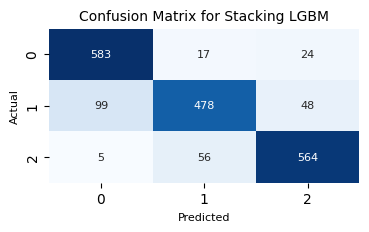

{'classifier': 'Stacking GDB', 'mean_accuracy': 0.859298780487805, 'mean_precision': 0.8605960457293584, 'mean_recall': 0.8593046543298886, 'mean_f1_score': 0.8580785160312056, 'std_accuracy': 0.0057159552619672665, 'std_precision': 0.005956735028993612, 'std_recall': 0.00570749940269418, 'std_f1_score': 0.005945512408449661, 'cohen_kappa': 0.8079026597469027, 'confusion_matrix': array([[585,  17,  22],
       [100, 482,  43],
       [  2,  56, 567]]), 'elapsed_time': 674.0541110038757}


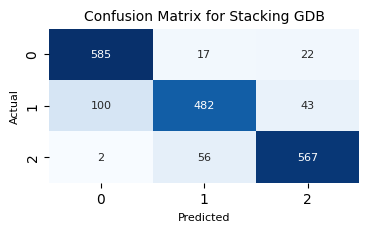

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'classifier': 'Stacking Log Reg', 'mean_accuracy': 0.8387195121951219, 'mean_precision': 0.8405997292045088, 'mean_recall': 0.8387323281401837, 'mean_f1_score': 0.838507387280039, 'std_accuracy': 0.005796693092021835, 'std_precision': 0.006209784703855919, 'std_recall': 0.005754348520907599, 'std_f1_score': 0.005635012074302731, 'cohen_kappa': 0.7814887154909629, 'confusion_matrix': array([[561,  44,  19],
       [111, 477,  37],
       [  9,  53, 563]]), 'elapsed_time': 651.236340045929}


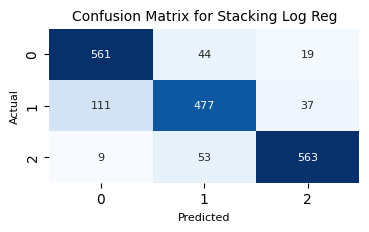

In [ ]:
# Stacking Classifiers
stacking_classifiers = {
    "Stacking LGBM": StackingClassifier(estimators=[
        ('svm', SVC()),
        ('Extra Trees', ExtraTreesClassifier())
    ], final_estimator=LGBMClassifier()),
    "Stacking GDB": StackingClassifier(estimators=[
        ('svm', SVC()),
        ('Extra Trees', ExtraTreesClassifier())
    ], final_estimator=GradientBoostingClassifier()),
    "Stacking Log Reg": StackingClassifier(estimators=[
        ('svm', SVC()),
        ('Extra Trees', ExtraTreesClassifier())
    ], final_estimator=LogisticRegression())
}

# Train and evaluate stacking classifiers
for classifier_name, classifier in stacking_classifiers.items():
    results.append(train_and_evaluate_classifier(classifier, classifier_name))

In [ ]:
# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
df_results.sort_values(by='mean_accuracy', ascending=False)

,classifier,mean_accuracy,mean_precision,mean_recall,mean_f1_score,std_accuracy,std_precision,std_recall,std_f1_score,cohen_kappa,confusion_matrix,elapsed_time
10,Stacking GDB,0.859299,0.860596,0.859305,0.858079,0.005716,0.005957,0.005707,0.005946,0.807903,"[[585, 17, 22], [100, 482, 43], [2, 56, 567]]",674.054111
9,Stacking LGBM,0.851372,0.852045,0.851378,0.850101,0.007906,0.008220,0.007881,0.008151,0.800699,"[[583, 17, 24], [99, 478, 48], [5, 56, 564]]",660.369509
7,Extra Trees,0.846799,0.849078,0.846806,0.845993,0.008528,0.008712,0.008493,0.008466,0.784693,"[[582, 28, 14], [115, 468, 42], [14, 56, 555]]",108.280109
11,Stacking Log Reg,0.838720,0.840600,0.838732,0.838507,0.005797,0.006210,0.005754,0.005635,0.781489,"[[561, 44, 19], [111, 477, 37], [9, 53, 563]]",651.236340
2,Support Vector Machine,0.826829,0.830406,0.826838,0.827062,0.004996,0.005053,0.004972,0.004949,0.759878,"[[557, 47, 20], [112, 471, 42], [15, 64, 546]]",35.160359
3,Random Forest,0.824390,0.825809,0.824399,0.823788,0.010096,0.010976,0.010061,0.010069,0.758278,"[[556, 53, 15], [119, 460, 46], [12, 57, 556]]",75.500149
1,Decision Tree,0.785823,0.790055,0.785832,0.779429,0.009820,0.009473,0.009901,0.010403,0.708661,"[[584, 29, 11], [154, 372, 99], [21, 50, 554]]",5.293672
4,Logistic Regression,0.780945,0.781943,0.780954,0.780127,0.005467,0.005101,0.005419,0.005465,0.663028,"[[523, 62, 39], [118, 426, 81], [36, 85, 504]]",1.492080
8,LightGBM,0.765091,0.766317,0.765105,0.764354,0.009954,0.009424,0.009927,0.010268,0.678236,"[[527, 68, 29], [116, 436, 73], [37, 79, 509]]",17.997863
0,Naive Bayes,0.730183,0.733235,0.730184,0.730312,0.010473,0.009498,0.010477,0.010659,0.590186,"[[471, 93, 60], [114, 444, 67], [68, 110, 447]]",0.547911


In [ ]:
# gets the best model from all classifiers
best_model_name = df_results.loc[df_results['mean_accuracy'].idxmax(), 'classifier']
print(f"Best model: {best_model_name}")

Best model: Stacking GDB


# Saving the Model

In [ ]:
# Save the best model
model_directory = '/content/drive/MyDrive/Financial_Sentiment_Analysis/Model'
best_model = stacking_classifiers[best_model_name]

# Fit the best model on the full training set
best_model.fit(X_train, y_train)

# Save the model in the specified directory
with open(os.path.join(model_directory, 'model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)

# Save the vectorizer in the specified directory
with open(os.path.join(model_directory, 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer3, f)

# Loading the Model

In [ ]:
# Load the model
with open(os.path.join(model_directory, 'model.pkl'), 'rb') as f:
    model = pickle.load(f)

# Load the vectorizer
with open(os.path.join(model_directory, 'vectorizer.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)

In [ ]:
set_config(display='diagram')
model

StackingClassifier(estimators=[('svm', SVC()),
                               ('Extra Trees', ExtraTreesClassifier())],
                   final_estimator=GradientBoostingClassifier())

# Model Evaluation

In [ ]:
# Measure the execution time
start_time = time.time()

# Step 1: Make predictions on the test set
test_predicted = model.predict(X_test)

# Step 2: Calculate the test set metrics
test_accuracy = accuracy_score(y_test, test_predicted)
test_precision = precision_score(y_test, test_predicted, average='macro')
test_recall = recall_score(y_test, test_predicted, average='macro')
test_f1_score = f1_score(y_test, test_predicted, average='macro')
test_cohen_kappa = cohen_kappa_score(y_test, test_predicted)
test_cm = confusion_matrix(y_test, test_predicted)

# Measure the elapsed time
elapsed_time = time.time() - start_time

# Step 3: Create a DataFrame with the results
results_test = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "Cohen's Kappa",
        "Elapsed Time"
    ],
    "Value": [
        test_accuracy,
        test_precision,
        test_recall,
        test_f1_score,
        test_cohen_kappa,
        elapsed_time
    ]
})

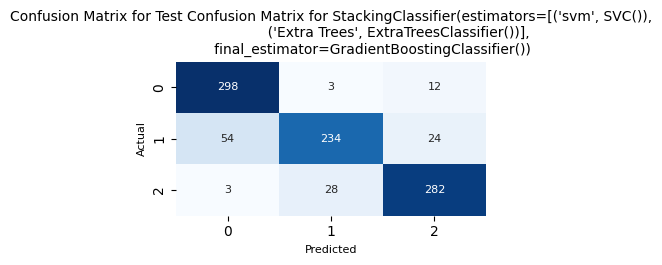

In [ ]:
# Plot confusion matrix for test set
plot_confusion_matrix(test_cm, f"Test Confusion Matrix for {model}")

In [ ]:
results_test

,Metric,Value
0,Accuracy,0.867804
1,Precision,0.869749
2,Recall,0.867678
3,F1 Score,0.865709
4,Cohen's Kappa,0.801690
5,Elapsed Time,1.168773
